In [6]:
import transformers

In [7]:
transformers.logging.set_verbosity_info

<function transformers.utils.logging.set_verbosity_info()>

In [14]:
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# 레이어 동결
NUM_OF_FREEZE = 12 # 12이하로 12는 전체 동결

for param in model.bert.encoder.layer[:NUM_OF_FREEZE].parameters():
    param.requires_grad = False

In [18]:
torch.cuda.empty_cache()

In [19]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**언어모델 및 Tokenizer 불러오기**

**데이터셋 가져오기**

In [20]:
data_path = "/root/merged_df_1000.csv"
data = pd.read_csv(data_path)
data.head()

,Unnamed: 0,class,conversation
0,0,일반 대화,내 친구도 한 번도 본 적이 없대.언니는 입마개 쓰는 거 본 적 있어?
1,1,일반 대화,밤에 방에서 혼자 보다 눈물 또르륵그치 ㅜㅜ 봐도 봐도 마지막 장면엔 눈물 쭈르륵....
2,2,협박 대화,어이 아가야 \n네.? 누구세요 . 아저씨.?\n아 나 니네 아빠 친구야. 많이 컸...
3,3,일반 대화,그거 하면 할인되는 거야? 어떤 거지? 너한테 처음 들음ㅋㅋ 나처럼 대중교통비 많이...
4,4,갈취 대화,친구야 내친구야\n무.무슨일이야?\n왜그렇게 쫄고그래?\n아니.\n그건 그렇고 너 ...


In [21]:
# class 대화 라벨링하기
data['class'].unique()

class_labels = {"협박 대화":0, 
                "갈취 대화":1, 
                "직장 내 괴롭힘 대화": 2, 
                "기타 괴롭힘 대화":3, 
                "일반 대화": 4}

data['label'] = data['class'].map(class_labels)

In [23]:
data.head()

,Unnamed: 0,class,conversation,label
0,0,일반 대화,내 친구도 한 번도 본 적이 없대.언니는 입마개 쓰는 거 본 적 있어?,4
1,1,일반 대화,밤에 방에서 혼자 보다 눈물 또르륵그치 ㅜㅜ 봐도 봐도 마지막 장면엔 눈물 쭈르륵....,4
2,2,협박 대화,어이 아가야 \n네.? 누구세요 . 아저씨.?\n아 나 니네 아빠 친구야. 많이 컸...,0
3,3,일반 대화,그거 하면 할인되는 거야? 어떤 거지? 너한테 처음 들음ㅋㅋ 나처럼 대중교통비 많이...,4
4,4,갈취 대화,친구야 내친구야\n무.무슨일이야?\n왜그렇게 쫄고그래?\n아니.\n그건 그렇고 너 ...,1


여기서 작은 모델만 training 하는 거니까 len 작게만...0.1만 뽑겠당.

In [24]:
len(data)

4950

In [25]:
# new_data_path = os.path.join(os.getenv('HOME'), "aiffel/dktc/test (2).csv")
# new_data = pd.read_csv(new_data_path)

In [26]:
# new_data.head()

In [27]:
# test_data = new_data['text'].tolist()

In [28]:
sampled_data = data
sampled_data['conversation'] = sampled_data['conversation'].str.replace('\n', " ")


In [29]:
sampled_data['conversation'] = sampled_data['conversation'].str.replace('nan', "")


In [30]:
(sampled_data['conversation'].str.startswith('nan') == True).count()

np.int64(4950)

In [31]:
sampled_data['conversation'].dropna(inplace=True)
len(sampled_data)

4950

In [32]:
sampled_data['label'].value_counts()

label
3    1094
4    1000
1     981
2     979
0     896
Name: count, dtype: int64

In [33]:
#결측치 확인
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    4950 non-null   int64 
 1   class         4950 non-null   object
 2   conversation  4950 non-null   object
 3   label         4950 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 154.8+ KB


In [34]:
#중복값 확인
sampled_data[sampled_data['conversation'].duplicated()]


,Unnamed: 0,class,conversation,label
418,418,기타 괴롭힘 대화,새파랗게 젊은게 어디 여길 앉아있어 저 임산부에요 사지 멀쩡한게! 임신이 벼슬이냐?...,3
470,470,직장 내 괴롭힘 대화,김대리. 이번 주간 회의 발표 준비좀 해줘. 저 말입니까.? 응. 너가 해줘 과장님...,2
869,869,기타 괴롭힘 대화,니가 나 따라한다는 애구나? 내가? 나 너 안따라해. 머라는거야. 여기 사진 다 ...,3
993,993,기타 괴롭힘 대화,공책 돌려받길 원하면 빨리 뛰어봐. 이 굼벵아. 빨리 내놔. 빨릐 내놔아. 빨리 내...,3
1137,1137,기타 괴롭힘 대화,넌 얼굴이 왜 그렇게 생겼어? 내 얼굴이 왜? 다운증후군 걸린 애마냥 못생겼잖아 야...,3
...,...,...,...,...
4870,4870,직장 내 괴롭힘 대화,저 부장님 다음주에 연차 좀 쓰려고 하는데요 연차? 니가 왜 연차를 써 이 바쁜 와...,2
4874,4874,기타 괴롭힘 대화,맛이 쓰레기네요 별점 1개 드립니다 손님 어떤 부분이 부족했을까요? 정말 죄송합니다...,3
4910,4910,기타 괴롭힘 대화,푸핫 야 너 배좀 봐 밥이 들어가니? 아 왜그래요 아니 너만 보면 진짜 한심해서 그...,3
4923,4923,기타 괴롭힘 대화,야. 찐따야 오늘도 나왔네? 나 좀 내버려둬. 제발 찐따가 오늘 기분이 안 좋나? ...,3


In [35]:
#중복값 제거
#sampled_data.drop_duplicates(subset = ['conversation'], inpla
# ce = True)

In [36]:
# def remove_null_conversations(dataframe):
#     # 'conversation_split' 열의 null 값 찾기
#     null_conversations = dataframe[dataframe['conversation_split'].isnull()]

#     # null 값이 있는지 확인하고, 있다면 해당 행 제거
#     if not null_conversations.empty:
#         dataframe = dataframe.dropna(subset=['conversation_split'])

#     return dataframe

# 함수 호출
cleaned_data = sampled_data

# # 결과 확인
# cleaned_data['label'].value_counts()

In [37]:
nan_rows = cleaned_data[cleaned_data['conversation'].isna()].index.tolist()
nan_rows

[]

## BERT 불러오기

In [38]:
X_data = cleaned_data['conversation']
y_data = cleaned_data['label']

In [39]:
TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 2024
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y_data)  #stratify하면 데이터 분리 이전의 라벨별 비율을 고려해 데이터 분리

In [40]:
X_train

3293    너 중국에서 왔다며 ? 응 진짜 중국은 마약하면 죽냐? 응? 그게 무슨말이야 아니 ...
1507    우리 오늘 점심은 장어 먹읍시다 네 장어요? 왜 장어 못먹나 먹고 기운내게 아 제가...
1095    강인턴 이제부터 회사 업무 외 모든 일은 나한테 보고하고 다녀오게. 네.? 어떤 일...
3993    다들 의견 내보세요 아저는 안건이 더 좋다고 생각합니다 누가 자네 의견이 궁금하다했...
749     내일 학교올때 십만원 가져와 이제 더이상 구할데가없어 너네 부모님에게 부탁해 안돼 ...
                              ...                        
1858             아침에 srt 추석 예매 대실패~와 그거 들어가면 대기시간 얼마나 나와?
680     사장님 장사하기 싫소? 왜이러는가자네. 자릿세 내라고 말햇어안햇어? 아니 요즘세상에...
3737    401호시죠? 저 301호에요. 밤에 너무 천장이 울려서 잠을 잘 수 없어요. 운동...
3556    친구야 머하냐? 이거 정말 간지난다. 그지 이거 간지나지? 아빠가 두바이 갔다 오면...
3474    너 지갑있지 없는데 만원만줘 없다니까 나 당장급해서그래 빌려주라갚아줄게 너가 갚아준...
Name: conversation, Length: 3960, dtype: object

In [41]:
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()
y_train_list = y_train.tolist()
y_test_list = y_test.tolist()

In [42]:
print(type(X_train_list))

<class 'list'>


In [43]:
ans_train = torch.tensor(y_train_list)

In [44]:
ans_train

tensor([3, 2, 2,  ..., 0, 1, 1])

In [45]:
def create_batches(input_list, output_list, batch_size):
  assert len(input_list) == len(output_list)
  for i in range(0, len(input_list), batch_size):
        yield (input_list[i:i + batch_size], output_list[i:i + batch_size])

BATCH_SIZE = 64  # You can adjust this as needed

In [46]:
# 런타임 1분 소요
# 활성화 함수 AdamW 불러오기
from transformers import AdamW

# 활성화 함수 AdamW 인스턴스화
optimizer = AdamW(model.parameters(), lr=0.00001)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [47]:
%%time
# 모델을 학습 모드로 변경
model.train()

# 에포크 수 지정 및 손실을 담은 빈 컨테이너 리스트 생성
epochs = 5
losses = []

# 동결 후 추가된 층만 훈련
for epoch in range(epochs):
    temp = []
    for batch, labels in create_batches(X_train_list, ans_train, BATCH_SIZE):
        inputs = tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        labels = labels.to(device)
        
        # 그래디언트(기울기) 초기화
        optimizer.zero_grad()
        # 변수 eval_list에 담긴 여섯 개 문장을 토크나이저에 넣고 인코딩
        #inputs = tokenizer.batch_encode_plus(X_train_list, return_tensors="pt", padding=True, truncation=True)
        # 위에서 생성된 input 변수에 담긴 키(key)와 키값(value)을 **inputs 형식(**kwargs 형식)으로 모델에 전달
        # 거기에 추가로 labels를 텐서 타입으로 모델에 전달
        outputs = model(**inputs, labels=labels)
        # 로짓 추출
        logits = outputs.logits
        
        # print(outputs.loss)
        # break
    
        # 손실 추출
        loss = outputs.loss
        
        # 오차역전파
        loss.backward()

        # 가중치(weight) 업데이트
        optimizer.step()

        # 손실을 빈 컨테이너 losses에 순서대로 저장
        temp.append(loss)

        # 에포크 및 손실 값 출력

    # 에폭당 평균 손실 계산 및 출력
    avg_epoch_loss = sum(temp) / len(temp)
    print(f"epoch:{epoch+1}, average loss:{avg_epoch_loss}")
    losses.append(avg_epoch_loss)

epoch:1, average loss:1.5588747262954712
epoch:2, average loss:1.3576208353042603
epoch:3, average loss:1.2029882669448853
epoch:4, average loss:1.0725219249725342
epoch:5, average loss:0.9573574066162109
CPU times: user 1min 32s, sys: 996 ms, total: 1min 33s
Wall time: 1min 25s


In [48]:
new_losses = [i.item() for i in losses]
print(new_losses)

[1.5588747262954712, 1.3576208353042603, 1.2029882669448853, 1.0725219249725342, 0.9573574066162109]


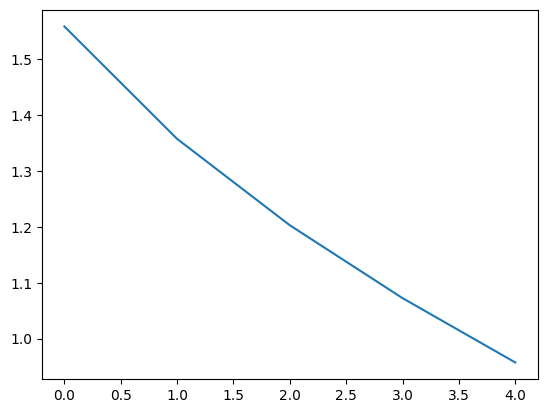

In [49]:
import matplotlib.pyplot as plt
plt.plot(new_losses);


In [50]:
t = [i for i in range(10)]
t[:-3], t[-3:]

([0, 1, 2, 3, 4, 5, 6], [7, 8, 9])

In [51]:
# 동결 모델 저장
# model save

model.save_pretrained("/root/ckpt/kluebert_trasfer_learning", from_pt=True) 

In [ ]:
# 동결 후 3개 풀기
NUM_OF_UNFREEZE = 9

for param in model.bert.encoder.layer[-NUM_OF_UNFREEZE:].parameters():
    param.requires_grad = True

In [ ]:
%%time

# 에포크 수 지정 및 손실을 담은 빈 컨테이너 리스트 생성
epochs = 5
losses = []

# 파인튜닝
for epoch in range(epochs):
    temp = []
    for batch, labels in create_batches(X_train_list, ans_train, BATCH_SIZE):
        inputs = tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        labels = labels.to(device)
        
        # 그래디언트(기울기) 초기화
        optimizer.zero_grad()
        # 변수 eval_list에 담긴 여섯 개 문장을 토크나이저에 넣고 인코딩
        #inputs = tokenizer.batch_encode_plus(X_train_list, return_tensors="pt", padding=True, truncation=True)
        # 위에서 생성된 input 변수에 담긴 키(key)와 키값(value)을 **inputs 형식(**kwargs 형식)으로 모델에 전달
        # 거기에 추가로 labels를 텐서 타입으로 모델에 전달
        outputs = model(**inputs, labels=labels)
        # 로짓 추출
        logits = outputs.logits
        
        # print(outputs.loss)
        # break
    
        # 손실 추출
        loss = outputs.loss
        
        # 오차역전파
        loss.backward()

        # 가중치(weight) 업데이트
        optimizer.step()

        # 손실을 빈 컨테이너 losses에 순서대로 저장
        temp.append(loss)

        # 에포크 및 손실 값 출력

    # 에폭당 평균 손실 계산 및 출력
    avg_epoch_loss = sum(temp) / len(temp)
    print(f"epoch:{epoch+1}, average loss:{avg_epoch_loss}")
    losses.append(avg_epoch_loss)

In [ ]:
for k, v in class_labels.items():
    print(k, v)

In [ ]:
dic = {v:k for k, v in class_labels.items()}
dic

In [ ]:
# 파인 튜닝 이후 추론
# 모델을 eval 모델로 전환
model.eval()

# 모델 예측을 담을 preds라는 빈 컨테이너 리스트 생성
preds = []

# 이하 코드의 설명은 문제 45 코드 참조
with torch.no_grad():
  for sentence in X_test_list:
    inputs = tokenizer.encode(sentence, return_tensors="pt",padding=True, truncation=True)
    inputs = inputs.to(device)
    outputs = model(inputs)
    logits = outputs.logits
    pred = logits.argmax(-1).item()
    logits = logits.detach().cpu().numpy()
    preds.append(logits.argmax(-1).item())
    print(f"{dic[pred]}:{sentence}")



In [ ]:
ans = torch.tensor(y_test_list)
preds = torch.tensor(preds)
print(f"Accuracy:{100 * sum(ans.detach().clone()==preds)/len(ans.detach().clone())}%")

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
preds_tensor = torch.tensor(preds).tolist()

# 실제 라벨 (y_test_list)와 예측 라벨 (preds_tensor) 비교하여 F1 Score 계산
f1 = f1_score(y_test_list, preds_tensor, average='weighted')
print(f"F1 Score: {f1}")

In [ ]:
type(model)

In [ ]:
# model save
model.save_pretrained("/root/ckpt/finetune_kluebert_first", from_pt=True) 


# Inference

In [ ]:
# import re
# from tqdm import tqdm
# import urllib.request
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
#                             roc_auc_score, confusion_matrix, classification_report, \
#                             matthews_corrcoef, cohen_kappa_score, log_loss
# from torch import nn
# import torch
# from torch.utils.data import Dataset, DataLoader

In [ ]:
# # model load
# model = AutoModelForSequenceClassification.from_pretrained("/root/ckpt/finetune_kluebert_first")
# model.to(device)

In [ ]:
# load test.csv
test_df = pd.read_csv('/root/test.csv', index_col=0)
test_df.head()

In [ ]:
X_test_list = test_df['text'].tolist()

In [ ]:
device

In [ ]:
# evaluation for test and make submission.csv
# 파인 튜닝 이후 추론
# 모델을 eval 모델로 전환
model.eval()

# 모델 예측을 담을 preds라는 빈 컨테이너 리스트 생성
preds = []

# 이하 코드의 설명은 문제 45 코드 참조
with torch.no_grad():
  for sentence in X_test_list:
    
    inputs = tokenizer.encode(sentence, return_tensors="pt",padding=True, truncation=True)
    inputs = inputs.to(device)
    
    outputs = model(inputs)
    
    logits = outputs.logits
    pred = logits.argmax(-1).item()
    logits = logits.detach().cpu().numpy()
    preds.append(logits.argmax(-1).item())
    print(f"{dic[pred]}:{sentence}")



In [ ]:
# add to test_df
test_df['class'] = preds
test_df

In [ ]:
test_df['class'].value_counts()

In [ ]:
# Save result dataset for leaderboard
test_df.to_csv('/root/new_submission_2_freeze_unfreeze.csv')